In [390]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Carregar os dados
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/concrete.csv')

df.head()


,5.400000000000000000e+02,0.000000000000000000e+00,0.000000000000000000e+00.1,1.620000000000000000e+02,2.500000000000000000e+00,1.040000000000000000e+03,6.760000000000000000e+02,2.800000000000000000e+01,7.998999999999999488e+01
0,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0,61.89
1,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270.0,40.27
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365.0,41.05
3,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360.0,44.30
4,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90.0,47.03


In [392]:
X = df.iloc[:, :-1].values  # As primeiras 8 colunas são os atributos
y = df.iloc[:, -1].values   # A última coluna é a saída (resistência)

# Separação dos dados em treino (60%), validação (20%) e teste (20%)
n_samples = X.shape[0]
indices = np.random.permutation(n_samples)
train_idx = indices[:int(0.6 * n_samples)]
val_idx = indices[int(0.6 * n_samples):int(0.8 * n_samples)]
test_idx = indices[int(0.8 * n_samples):]

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Normalização Min-Max usando apenas os dados de treino
X_min, X_max = np.min(X_train, axis=0), np.max(X_train, axis=0)
X_train = (X_train - X_min) / (X_max - X_min)

# Aplica a normalização Min-Max ao conjunto de validação e teste usando os mesmos parâmetros
X_val = (X_val - X_min) / (X_max - X_min)
X_test = (X_test - X_min) / (X_max - X_min)

# Normaliza y usando apenas os dados de treino
y_min, y_max = np.min(y_train), np.max(y_train)
y_train = (y_train - y_min) / (y_max - y_min)

# Aplica a normalização Min-Max ao conjunto de validação e teste usando os mesmos parâmetros
y_val = (y_val - y_min) / (y_max - y_min)
y_test = (y_test - y_min) / (y_max - y_min)



In [393]:
# Inicialização de parâmetros
n_inputs = X_train.shape[1]  # Número de atributos (8)
n_hidden = 16  # Número de neurônios na camada oculta
n_outputs = 1  # Saída


W1 = np.random.uniform(-0.5, 0.5, (n_inputs, n_hidden))  # Pesos entre camada de entrada e oculta
b1 = np.zeros((n_hidden,))
W2 = np.random.uniform(-0.5, 0.5, (n_hidden, n_outputs))  # Pesos entre camada oculta e saída
b2 = np.zeros((n_outputs,))

# Hiperparâmetros
learning_rate = 0.00001
momentum = 0.9
n_epochs = 10000
batch_size = 64

# Velocidade do momentum
v_W1, v_b1 = np.zeros_like(W1), np.zeros_like(b1)
v_W2, v_b2 = np.zeros_like(W2), np.zeros_like(b2)

In [394]:
# Funções de ativação

# Função ReLU
def relu(z):
    return np.maximum(0, z)

# Derivada da ReLU
def relu_derivative(z):
    return (z > 0).astype(float)


In [395]:
# Calcula a saída da rede neural

def forward_pass(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1  # Entrada da camada oculta
    a1 = relu(z1)         # Saída da camada oculta
    z2 = np.dot(a1, W2) + b2  # Saída final (sem ativação na saída)
    return z1, a1, z2

# Erro quadrático médio
def rmse(y_true, y_pred):
    return math.sqrt(np.mean((y_true - y_pred) ** 2))


def mae(y_true, y_pred):
    return (abs(y_true - y_pred)).mean()


def mre(y_true, y_pred):
    e = 1e-8  # Um pequeno valor para evitar divisão por zero

    y_true_safe = np.where(np.abs(y_true) < e, e, y_true)

    return (abs(y_true_safe - y_pred) / np.abs(y_true_safe)).mean()


In [396]:
# Backpropagation e atualização dos pesos
def backprop(X, y, W1, b1, W2, b2, v_W1, v_b1, v_W2, v_b2, learning_rate, momentum):

    z1, a1, z2 = forward_pass(X, W1, b1, W2, b2)

    # Erro na saída
    error_output = z2 - y.reshape(-1, 1)

    # Gradientes para a camada de saída
    dW2 = np.dot(a1.T, error_output) / len(y)
    db2 = np.mean(error_output, axis=0)

    # Erro na camada oculta
    error_hidden = np.dot(error_output, W2.T) * relu_derivative(z1)

    # Gradientes para a camada oculta
    dW1 = np.dot(X.T, error_hidden) / len(y)
    db1 = np.mean(error_hidden, axis=0)

    # Atualização dos pesos com momentum
    v_W2 = momentum * v_W2 - learning_rate * dW2
    v_b2 = momentum * v_b2 - learning_rate * db2
    v_W1 = momentum * v_W1 - learning_rate * dW1
    v_b1 = momentum * v_b1 - learning_rate * db1

    W2 += v_W2
    b2 += v_b2
    W1 += v_W1
    b1 += v_b1

    return W1, b1, W2, b2, v_W1, v_b1, v_W2, v_b2



In [397]:
def denormalize(y_normalized, y_min, y_max):
    return y_normalized * (y_max - y_min) + y_min

train_losses = []
val_losses = []

# No treinamento
for epoch in range(n_epochs):
    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Minibatch
    for i in range(0, X_train.shape[0], batch_size):
        X_batch = X_train_shuffled[i:i + batch_size]
        y_batch = y_train_shuffled[i:i + batch_size]

        # Backpropagation e atualização de pesos
        W1, b1, W2, b2, v_W1, v_b1, v_W2, v_b2 = backprop(X_batch, y_batch, W1, b1, W2, b2, v_W1, v_b1, v_W2, v_b2, learning_rate, momentum)

    # Calculando as previsões normalizadas
    _, _, y_pred_train_normalized = forward_pass(X_train, W1, b1, W2, b2)
    _, _, y_pred_val_normalized = forward_pass(X_val, W1, b1, W2, b2)

    # Desnormalizar as previsões
    y_pred_train = denormalize(y_pred_train_normalized, y_min, y_max)
    y_pred_val = denormalize(y_pred_val_normalized, y_min, y_max)

    # Calculando o erro de treinamento na escala original
    train_loss = rmse(y_train * (y_max - y_min) + y_min, y_pred_train)

    # Calculando o erro de validação na escala original
    val_loss = rmse(y_val * (y_max - y_min) + y_min, y_pred_val)

    # Armazenando os erros
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}")

# Avaliação no conjunto de teste
_, _, y_pred_test_normalized = forward_pass(X_test, W1, b1, W2, b2)
y_pred_test = denormalize(y_pred_test_normalized, y_min, y_max)
test_loss = rmse(y_test * (y_max - y_min) + y_min, y_pred_test)
print(f"Test Loss: {test_loss}")


Epoch 0, Train Loss: 45.24017307689234, Val Loss: 45.704003573114015
Epoch 100, Train Loss: 38.358133861627245, Val Loss: 38.767513095329086
Epoch 200, Train Loss: 32.96490973618122, Val Loss: 33.34174674686624
Epoch 300, Train Loss: 28.778820132867807, Val Loss: 29.135134955182885
Epoch 400, Train Loss: 25.585310205315068, Val Loss: 25.92137395245739
Epoch 500, Train Loss: 23.19394124575722, Val Loss: 23.503861287192663
Epoch 600, Train Loss: 21.435133484574617, Val Loss: 21.719020456121665
Epoch 700, Train Loss: 20.169421141764186, Val Loss: 20.42867248699663
Epoch 800, Train Loss: 19.28328845824152, Val Loss: 19.516598381948448
Epoch 900, Train Loss: 18.671763296578078, Val Loss: 18.880601346623383
Epoch 1000, Train Loss: 18.256188973873314, Val Loss: 18.443962085222765
Epoch 1100, Train Loss: 17.976835134290095, Val Loss: 18.146381406854434
Epoch 1200, Train Loss: 17.79065327358168, Val Loss: 17.945076796036005
Epoch 1300, Train Loss: 17.667015620680026, Val Loss: 17.80855648267651

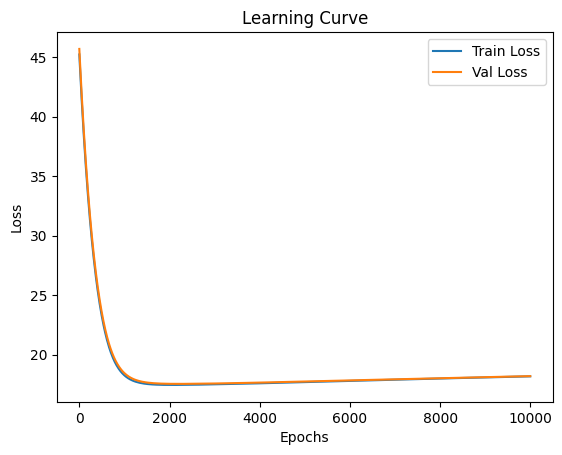

In [398]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [399]:


# Métricas de erro
def evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, W1, b1, W2, b2):
    # Previsões
    _, _, y_pred_train = forward_pass(X_train, W1, b1, W2, b2)
    _, _, y_pred_val = forward_pass(X_val, W1, b1, W2, b2)
    _, _, y_pred_test = forward_pass(X_test, W1, b1, W2, b2)

    # Convertendo previsões para o formato de array
    y_pred_train = y_pred_train.flatten()
    y_pred_val = y_pred_val.flatten()
    y_pred_test = y_pred_test.flatten()


    metrics = {
        'Treinamento': {
            'RMSE': rmse(y_train, y_pred_train),
            'MAE': mae(y_train, y_pred_train),
            'MRE': mre(y_train, y_pred_train),
        },
        'Validação': {
            'RMSE': rmse(y_val, y_pred_val),
            'MAE': mae(y_val, y_pred_val),
            'MRE': mre(y_val, y_pred_val),
        },
        'Teste': {
            'RMSE': rmse(y_test, y_pred_test),
            'MAE': mae(y_test, y_pred_test),
            'MRE': mre(y_test, y_pred_test),
        }
    }


    metrics_df = pd.DataFrame(metrics).T
    print("Métricas de Avaliação:")
    print(metrics_df)




evaluate_model(X_train, y_train, X_val, y_val, X_test, y_test, W1, b1, W2, b2)


Métricas de Avaliação:
                 RMSE       MAE           MRE
Treinamento  0.173084  0.139650  51806.568610
Validação    0.169617  0.136538      0.516994
Teste        0.165487  0.135144      0.616045
